# Notebook to make Fig. 7: alternate precession parameterizations

In [1]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
import importlib

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D
from textwrap import wrap

import seaborn as sns
cp = sns.color_palette('colorblind')
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("",['#CC79A7', '#D55E00', '#E69F00', '#0072B2'])

from helper_functions import *
from alternative_parametrizations import * 

import sys
sys.path.append('../utils')
import reconstructwf as rwf

style.use('plotting.mplstyle')

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


### Load samples

Computed in `alternative_parametrizations.py` or this notebook

In [2]:
# Where to save 
data_dir = '/Users/smiller/Documents/gw190521-timedomain-release/data_simonas_laptop/' 
savepath = data_dir + 'alternate_precession_parametrizations.npy'

reload = True

# If posteriors for alternative parametrizations generated already, load them in 
if os.path.exists(savepath) and reload:
    posteriors = np.load(data_dir+'alternate_precession_parametrizations.npy', allow_pickle=True).item()
    runs = posteriors.keys()
    
# If not, calculate them 
else:
    posteriors = {}
    
    # Load TD posterior samples 
    template = data_dir+'063023_gw190521_{0}_NRSur7dq4_dec8_flow11_fref11_{1}_TstartTend.dat'

    paths = {
        'full':template.format('full', '0M'),
        'm10M ':template.format('rd', 'm10M'),
        'm40M ':template.format('rd', 'm40M')
    }

    td_samples = {k: np.genfromtxt(p, names=True, dtype=float) for k, p in paths.items()}

    # Runs 
    runs = paths.keys()
    for run in runs:

        print(run)

        # Get samples
        samples =  td_samples[run]
        m1, m2 = m1m2_from_mtotq(samples['mtotal'], samples['q'])
        a1 = samples['chi1']
        a2 = samples['chi2']
        tilt1 = samples['tilt1']
        tilt2 = samples['tilt2']
        phi12 = samples['phi12']
        theta_jn = samples['theta_jn']
        phi_jl = samples['phi_jl']
        phi_ref = samples['phase']
        distance = samples['dist']

        # Transform spin convention
        f_ref = 11
        incl, s1x, s1y, s1z, s2x, s2y, s2z = transform_spins(theta_jn, phi_jl, tilt1, tilt2, 
                                                               phi12, a1, a2, m1, m2, f_ref, phi_ref)

        # Other info needed for calculating the other spin parameterizations
        duration = 0.7    
        t0_0M_geo = 1242442967.405764
        ra = 6.07546535866838
        dec = -0.8000357325337637
        psi = 2.443070879119043
        psd_filenames = {k:data_dir+f'GW190521_data/glitch_median_PSD_forLI_{k}.dat' for k in ['H1', 'L1', 'V1']}


        # Traditional chi_p 
        chip = chi_precessing(m1, a1, tilt1, m2, a2, tilt2)

        # Generalized chi_p
        gen_chip = calculate_generalizedChiP(m1, a1, tilt1, m2, a2, tilt2, phi12)

        # Mag. of chi_perp 
        mag_chiperp = calculate_magnitudeChiPerp(m1, m2, s1x, s1y, s1z, s2x, s2y, s2z)

        # Rho_p 
        rho_p = calculate_rhoP(m1, a1, tilt1, m2, a2, tilt2, phi12, incl, theta_jn, phi_jl, ra, 
                               dec, psi, t0_0M_geo, distance, phi_ref, f_ref, duration, psd_filenames)

        # Add to dict
        posteriors[run] = {
            'chip':chip,
            'gen chip':gen_chip, 
            'mag chiperp':mag_chiperp, 
            'rho_p':rho_p
        }

        # Save results as we go
        np.save(savepath, posteriors, allow_pickle=True)

### Make figure

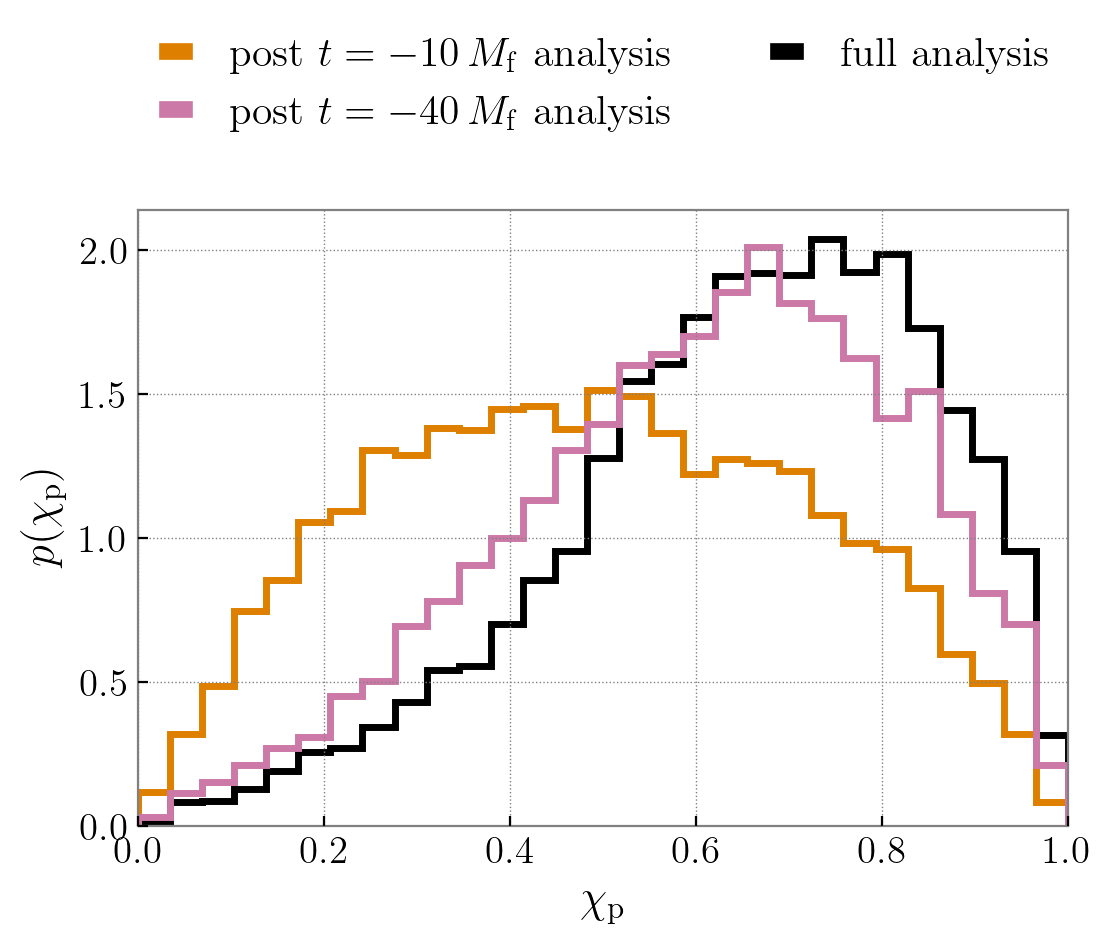

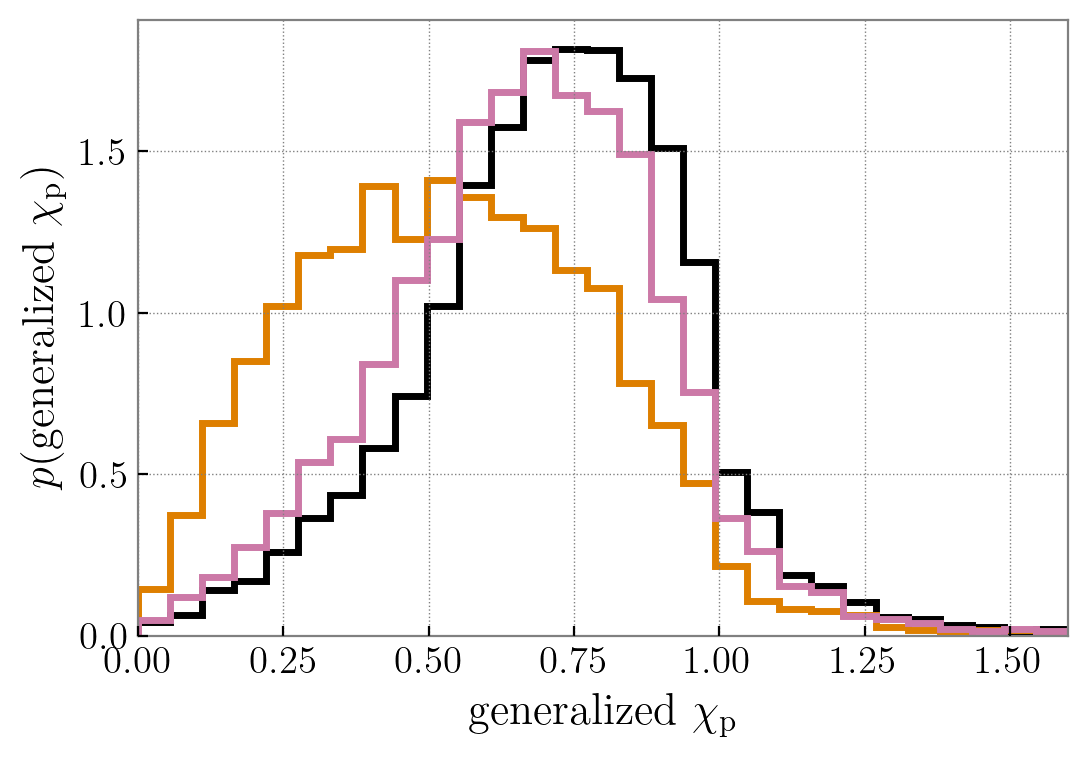

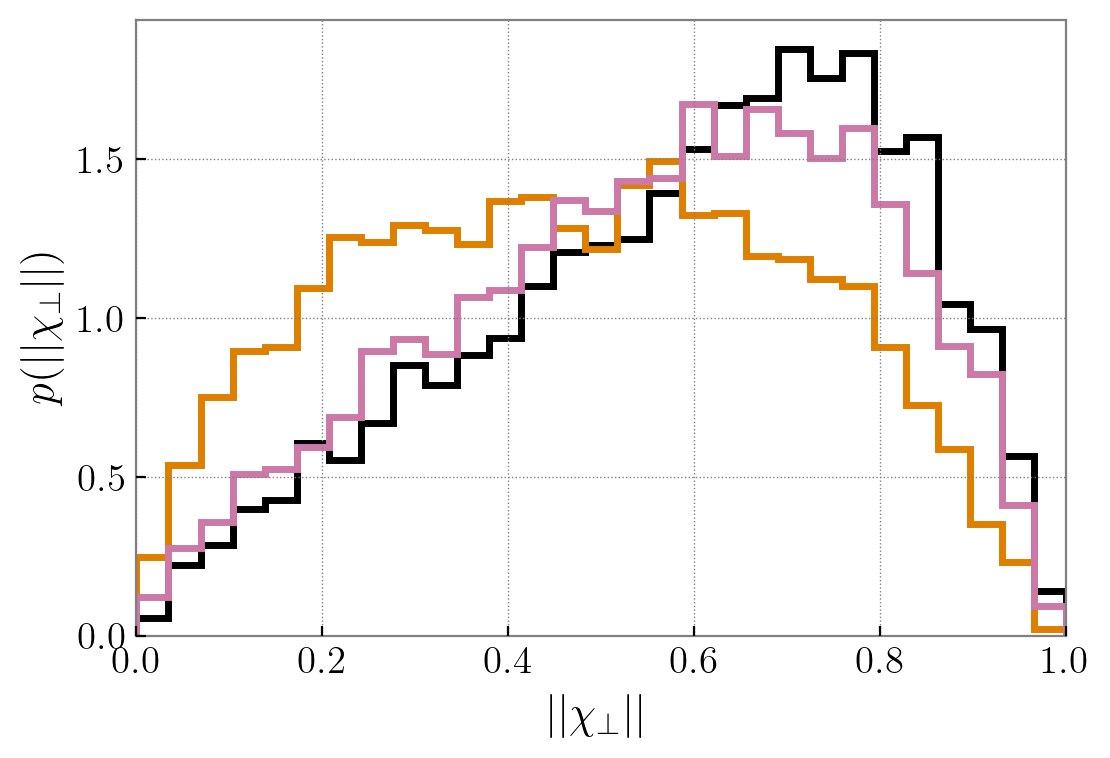

In [3]:
# Parameters
parameters = ['chip', 'gen chip', 'mag chiperp']

# Labels 
labels_dict = {
    'chip':r'\chi_\mathrm{p}',
    'gen chip':r'\mathrm{generalized}~\chi_\mathrm{p}', 
    'mag chiperp':r'||\chi_\perp||', 
    'rho_p':r'\rho_\mathrm{p}'
}

# Bounds 
bounds_dict = {
    'chip':[0,1],
    'gen chip':[0,1.6], 
    'mag chiperp':[0,1], 
    'rho_p':[0,2.5]
    
}

# Colors for runs
colors = ['k', cmap(0.5), cmap(0.001)]

# Save names for fig subplots
savenames = ['figure_07a.pdf', 'figure_07b.pdf', 'figure_07c.pdf']

# Make figure
for j, param in enumerate(parameters):
    
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    
    nbins = 30 
    bins = np.linspace(*bounds_dict[param], nbins)
    
    for i, run in enumerate(runs):
        samples = posteriors[run][param]
        plt.hist(samples, density=True, bins=bins, lw=2.5, histtype='step', color=colors[i])
        
    label = labels_dict[param]
    ax.set_xlabel(r'${0}$'.format(label), fontsize=16)
    ax.set_ylabel(r'$p({0})$'.format(label), fontsize=16)
    ax.set_xlim(*bounds_dict[param])
    
    if j==0: 
        handles = [
            Line2D([], [], color=colors[1], label='post $t = -10\,M_\mathrm{f}$ analysis'),
            Line2D([], [], color=colors[2], label='post $t = -40\,M_\mathrm{f}$ analysis'),
            Line2D([], [], color=colors[0], label='full analysis'),
        ]    
        plt.legend(handles=handles, bbox_to_anchor=(0., 1.1, 1., .102), loc='lower left',
                      ncols=2, mode="expand", borderaxespad=0., fontsize=15)
    
    plt.savefig(savenames[j], bbox_inches='tight')
    plt.show()

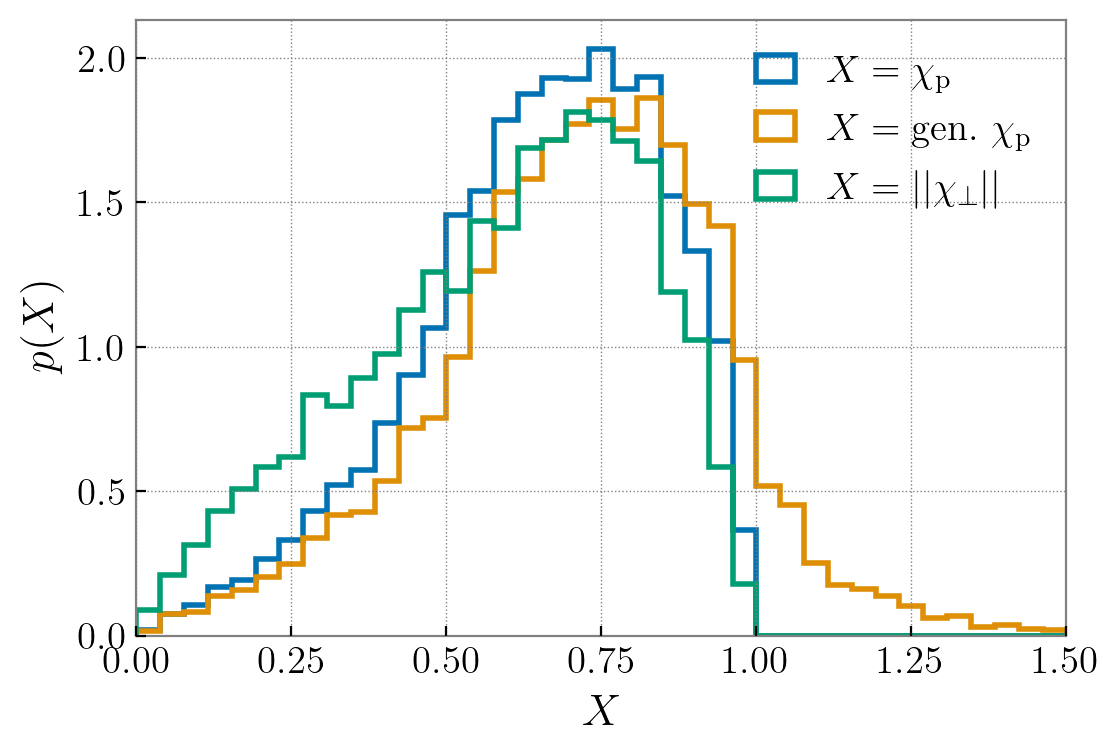

In [4]:
# Parameters
parameters = ['chip', 'gen chip', 'mag chiperp']

labels = [r'$X=\chi_\mathrm{p}$', r'$X=\mathrm{gen.}~\chi_\mathrm{p}$', r'$X=||\chi_\perp||$']

bins = np.linspace(0,1.5,40)

fig, ax = plt.subplots(1, 1, figsize=(6,4))

# Make figure
for j, param in enumerate(parameters):
    
    samples = posteriors['full'][param]
    plt.hist(samples, density=True, lw=2, histtype='step', bins=bins, label=labels[j], color=cp[j])
    
plt.xlim(bins[0], bins[-1])
plt.xlabel(r'$X$', fontsize=16)
plt.ylabel(r'$p(X)$', fontsize=16)
plt.legend()
plt.show()